# **1. Use fixed initialization**

In [ ]:
import numpy as np

In [ ]:
# Example code for reading the data and the initial weights and biases.
# Note: This is just an example of how to read these files, you can modify the code in your own implementation.

train_x, train_y = np.load('fashion_mnist/train_x.npy'), np.load('fashion_mnist/train_y.npy')
test_x, test_y = np.load('fashion_mnist/test_x.npy'), np.load('fashion_mnist/test_y.npy')

print('shape of data:')
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

checkpoint = np.load('weights.npy', allow_pickle=True).item()
#checkpoint = checkpoint.astype('float128')
init_weights = checkpoint['w']
init_biases = checkpoint['b']

print('shape of weights:')
for w in init_weights:
    print(w.shape)

print()

print('shape of biases:')
for b in init_biases:
    print(b.shape)

shape of data:
(30000, 784)
(30000,)
(5000, 784)
(5000,)
shape of weights:
(784, 2048)
(2048, 512)
(512, 5)

shape of biases:
(2048,)
(512,)
(5,)


In [ ]:
EPOCH = 20
Batch_size = 200
Learning_rate = 0.001

In [ ]:
#train_x_norm = train_x.astype('float32')
#test_x_norm = test_x.astype('float32')
# normalize to range 0-1
train_norm = train_x / 255.0
test_norm = test_x / 255.0

train_image_num = train_norm.shape[0]
test_image_num = test_norm.shape[0]
train_batch_num = train_image_num //Batch_size
# test_batch_num = test_image_num//Batch_size

label_temp = np.zeros((train_image_num, 5), dtype = np.float64)
for i in range(train_image_num):
    label_temp[i][train_y[i]] = 1
train_label_onehot = np.copy(label_temp)

test_label_temp = np.zeros((test_image_num, 5), dtype = np.float64)
for i in range(test_image_num):
    test_label_temp[i][test_y[i]] = 1
test_label_onehot = np.copy(test_label_temp)

print("One-hot training labels shape:",train_label_onehot.shape)
print("One-hot testing labels shape:",test_label_onehot.shape)


One-hot training labels shape: (30000, 5)
One-hot testing labels shape: (5000, 5)


In [ ]:
class _Layer(object):
    def __init__(self):
        pass

    def forward(self, *input):
        r"""Define the forward propagation of this layer.

        Should be overridden by all subclasses.
        """
        
        raise NotImplementedError

    def backward(self, *output_grad):
        r"""Define the backward propagation of this layer.

        Should be overridden by all subclasses.
        """
        raise NotImplementedError
        

class FullyConnected(_Layer):
    def __init__(self,n_in,n_out, weights, biases):
        self.weights = weights
        self.biases = biases
    def forward(self, x):
        self.old_x = x
        #print('FullyConnected forward input', x)
        #print('shape', self.weights.shape, self.biases.shape)
        #print('self.weight',self.weights, 'b', self.biases )
        #print('output of FC,', np.dot(x,self.weights) + self.biases )
        return np.dot(x,self.weights) + self.biases

    def backward(self,grad):
        #print('self.old_x',self.old_x)
        #print('grad', grad)
        self.grad_b = grad.mean(axis=0)
        self.grad_w = (np.matmul(self.old_x[:,:,None],grad[:,None,:])).mean(axis=0)
        return np.dot(grad,self.weights.transpose())

#00 - sigmoid
"""class ACTIVITY1(_Layer):
    def __init__(self):
        pass

    def forward(self, x):
        self.old_y = np.exp(x) / (1. + np.exp(x))
        return self.old_y


    def backward(self, grad):
        return self.old_y * (1. - self.old_y) * grad"""
#00 - relu
class Relu(_Layer):
    def __init__(self):
        self.old_x=None;
        pass

    def forward(self, x):     
        self.old_x = np.copy(x)
        return np.clip(x,0,None)


    def backward(self, grad):
        return np.where(self.old_x>0,grad,0)


class Softmax(_Layer):
    def __init__(self):
        self.old_y = None
    def forward(self,x):
            max = np.amax(x, axis = 1, keepdims = True)
            self.old_y = np.exp(x- max) / np.exp(x- max).sum(axis=1) [:,None]
            return self.old_y

    def backward(self,grad, yt):
            
            """for j in range(num_classes):
                  p = np.exp(f_i[j])/sum_i
                  dW[j, :] += (p-(j == y[i])) * X[:, i]"""
            #print('yt', yt.shape, yt)
            yt = self.old_y
            j_max = []
            for k in range(grad.shape[0]):
                jacobian_m = np.diag(yt[k])
                for i in range(len(jacobian_m)):
                    for j in range(len(jacobian_m)):
                        if i == j:
                            jacobian_m[i][j] = yt[k][i] * (1-yt[k][i])
                        else: 
                            jacobian_m[i][j] = -yt[k][i]*yt[k][j]
                der_dot_grad = np.dot(jacobian_m, grad[k].reshape((5, 1)))

                j_max.append(der_dot_grad)
            return np.array(j_max).reshape((200, 5))

            """j_max = []
            for k in range(grad.shape[0]): #self.old_y (200, 5)
                si_sj = - self.old_y[k] * self.old_y[k].reshape((5, 1))
                s_der = np.diag(self.old_y[k]) + si_sj
                s_der_grad = np.dot(s_der, grad[k].reshape((5, 1)))
                j_max.append(s_der_grad)
            #print('np.array(j_max)  shape', np.array(j_max).shape)
            return np.array(j_max).reshape((200, 5))"""
            """s = self.old_y.reshape(-1,1)
            return np.diagflat(s) - np.dot(s, s.T)"""

class CrossEntropy():
    def forward(self,x,y):
            self.old_x = x.clip(min=1e-8,max=None)
            self.old_y = y

            #return x,-np.sum(y*np.log(self.old_x))/x.shape[0]
            
            return x,-np.sum(y*np.log(self.old_x+1e-9))/x.shape[0]
            #return (np.where(y==1,-np.log(self.old_x), 0)).sum(axis=1)

    def backward(self):
            return self.old_y, np.where(self.old_y==1,-1/self.old_x, 0)
            #return self.old_y
    

In [ ]:
class Model(object):
    def __init__(self, layers, cost):
        self.layers = layers
        self.cost = cost
        self.pred = None
        self.training = None
    def forward(self,x):
        for layer in self.layers:
            
            x = layer.forward(x)
            #print('x', x)
        return x
    def train(self):
        self.training = True
        for layer in self.layers:
            if type(layer) == Dropout:
              layer.train()
    def eval(self):
        self.training = False
        for layer in self.layers:
            if type(layer) == Dropout:
              layer.eval()
    def loss(self,x,y):
        return self.cost.forward(self.forward(x),y)

    def backward(self):
        y, grad  = self.cost.backward()
        #print('cost backward', grad)
        for i in range(len(self.layers)-1,-1,-1):
            if type(self.layers[i]) == Softmax:
                grad = self.layers[i].backward(grad, y)
                
            elif(hasattr(self.layers[i], 'backward')):
                grad = self.layers[i].backward(grad)
                #print("backward",type(self.layers[i]), 'grad', grad)

In [ ]:
net1 = Model([FullyConnected(784,2048, init_weights[0], init_biases[0]),Relu(),FullyConnected(2048,512, init_weights[1], init_biases[1]),Relu(),FullyConnected(512,5, init_weights[2], init_biases[2]),Softmax()], CrossEntropy())


In [ ]:
from tqdm import tqdm
#np.seterr(divide='ignore',invalid='ignore')
loss = []
accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(1, EPOCH+1):
    
    train_loss=0
    val_loss=0
    train_hit = 0
    val_hit = 0
    total_train_loss = 0
    total_val_loss = 0
    for it in tqdm(range(train_batch_num)):
        #net1.train()
        pred,lo = net1.loss(train_norm[it*Batch_size:(it+1)*Batch_size], train_label_onehot[it*Batch_size:(it+1)*Batch_size])
        train_loss=lo.sum()
        pred_index = np.argmax(pred, axis=1)
        #print('pred_index', pred_index)
        train_hit += (pred_index==train_y[it*Batch_size:(it+1)*Batch_size]).sum()
        #print('train_y', train_y[it*Batch_size:(it+1)*Batch_size])
        
        total_train_loss += train_loss
        
        net1.backward()
        for layer in net1.layers:
            if type(layer) == FullyConnected:
                #print('update w', layer.grad_w)
                layer.weights -= Learning_rate * layer.grad_w
                layer.biases -= Learning_rate * layer.grad_b

        #net1.eval()
        test_pred,lo = net1.loss(test_norm, test_label_onehot)#.sum()
        val_loss=lo.sum()
        test_pred_index = np.argmax(test_pred, axis=1)
        hit = (test_pred_index==test_y).sum()
        val_hit += hit
        total_val_loss += val_loss

        if((it+1)%50 ==0):  
          loss.append(train_loss)
          accuracy.append((pred_index==train_y[it*Batch_size:(it+1)*Batch_size]).sum()/(Batch_size)*100.0)
          test_loss.append(val_loss)
          test_accuracy.append((test_pred_index==test_y).sum()/(test_image_num)*100.0)
   
        #print('Epoch:%3d'%epoch, '|Train Loss:%8.4f'%(total_train_loss/train_batch_num), '|Train Acc:%3.4f'%(train_hit/(train_image_num)*100.0) , '|Val Loss:%8.4f'%total_val_loss, '|Val Acc:%3.4f'%(val_hit/(test_image_num)*100.0))
        print('Epoch:%3d'%epoch, '|Train Loss:%8.4f'%(train_loss), '|Train Acc:%3.4f'%((pred_index==train_y[it*Batch_size:(it+1)*Batch_size]).sum()/(Batch_size)*100.0) , '|Val Loss:%8.4f'%(val_loss), '|Val Acc:%3.4f'%((test_pred_index==test_y).sum()/(test_image_num)*100.0))


   

In [ ]:
#save model weights & biases
from google.colab import drive
drive.mount('/content/drive')
weight = []
bias = []
for layer in net1.layers:
    if type(layer) == FullyConnected:
        weight.append(layer.weights)
        bias.append(layer.biases)
weight_np = np.array(weight)
bias_np = np.array(bias)
print('weight shape', weight_np.shape, 'bias shape', bias_np.shape)
with open('/content/drive/My Drive/trained_weights.npy', 'wb') as f:
    np.save(f, weight_np)
with open('/content/drive/My Drive/trained_biases.npy', 'wb') as f:   
    np.save(f, bias)

# The learning curves 

> black: training

> red:   testing





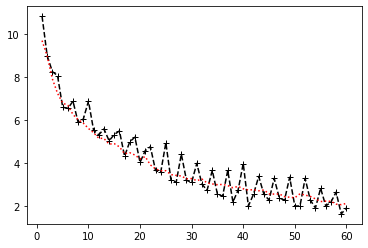

In [ ]:
import matplotlib.pyplot as plt
iter = []
for i in range(60):
    iter.append(i+1)
plt.plot(iter, loss, 'k--+')   # black dashed line, with "+" markers
plt.plot(iter, test_loss, 'r:')     # red dotted line (no marker)
plt.show()

# The classification accuracy

> black: training

> red:   testing





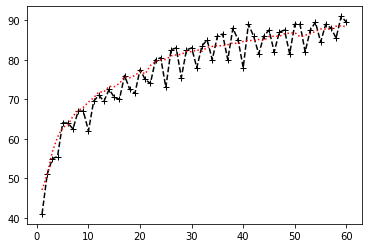

In [ ]:
for i in range(len(test_accuracy)):
  test_accuracy[i] *=100 

plt.plot(iter, accuracy, 'k--+')   # black dashed line, with "+" markers
plt.plot(iter, test_accuracy, 'r:')     # red dotted line (no marker)
plt.show()

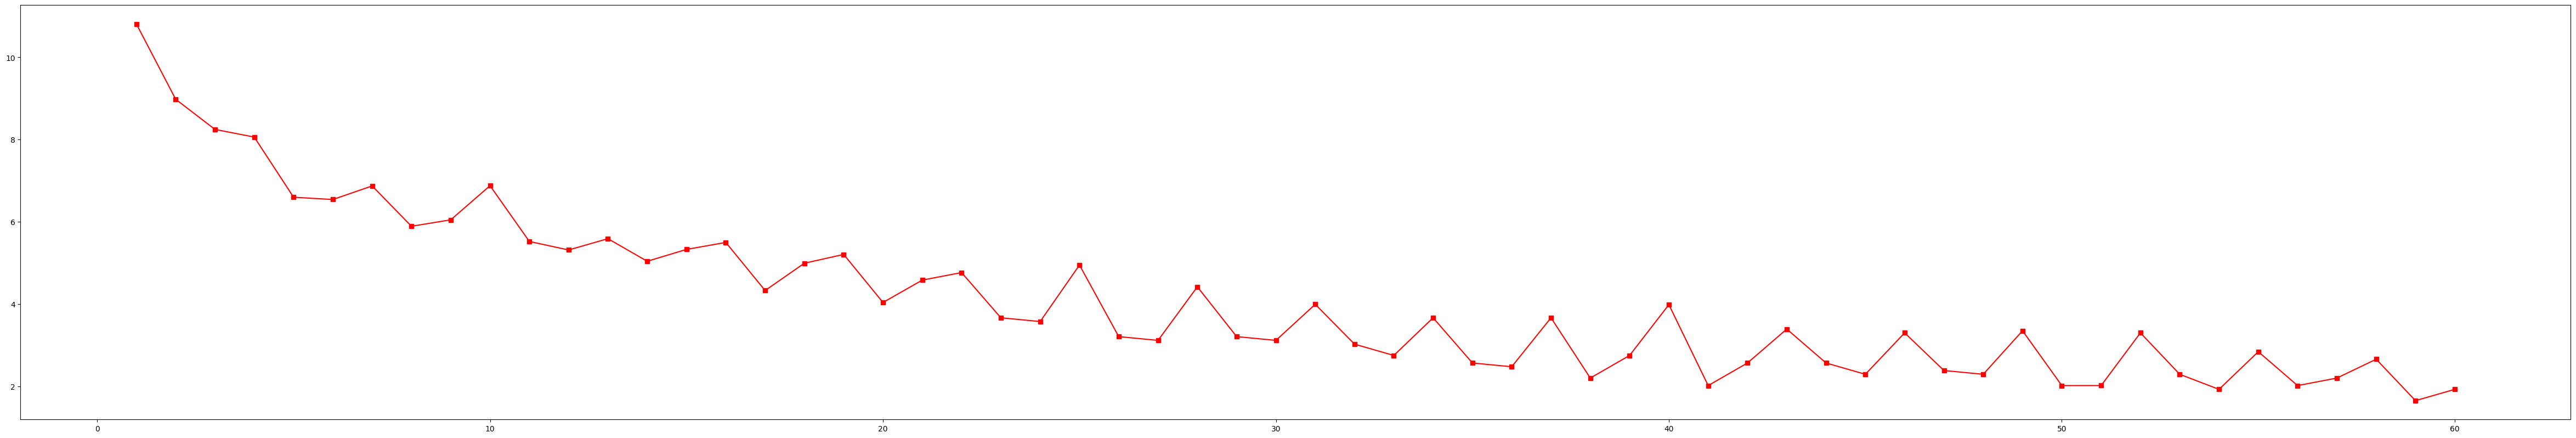

In [ ]:
import matplotlib.pyplot as plt
iter = []
for i in range(60):
    iter.append(i+1)
plt.figure(figsize=(60,10),dpi=100,linewidth = 2)
plt.plot(iter,loss,'s-',color = 'r', label="TSMC")

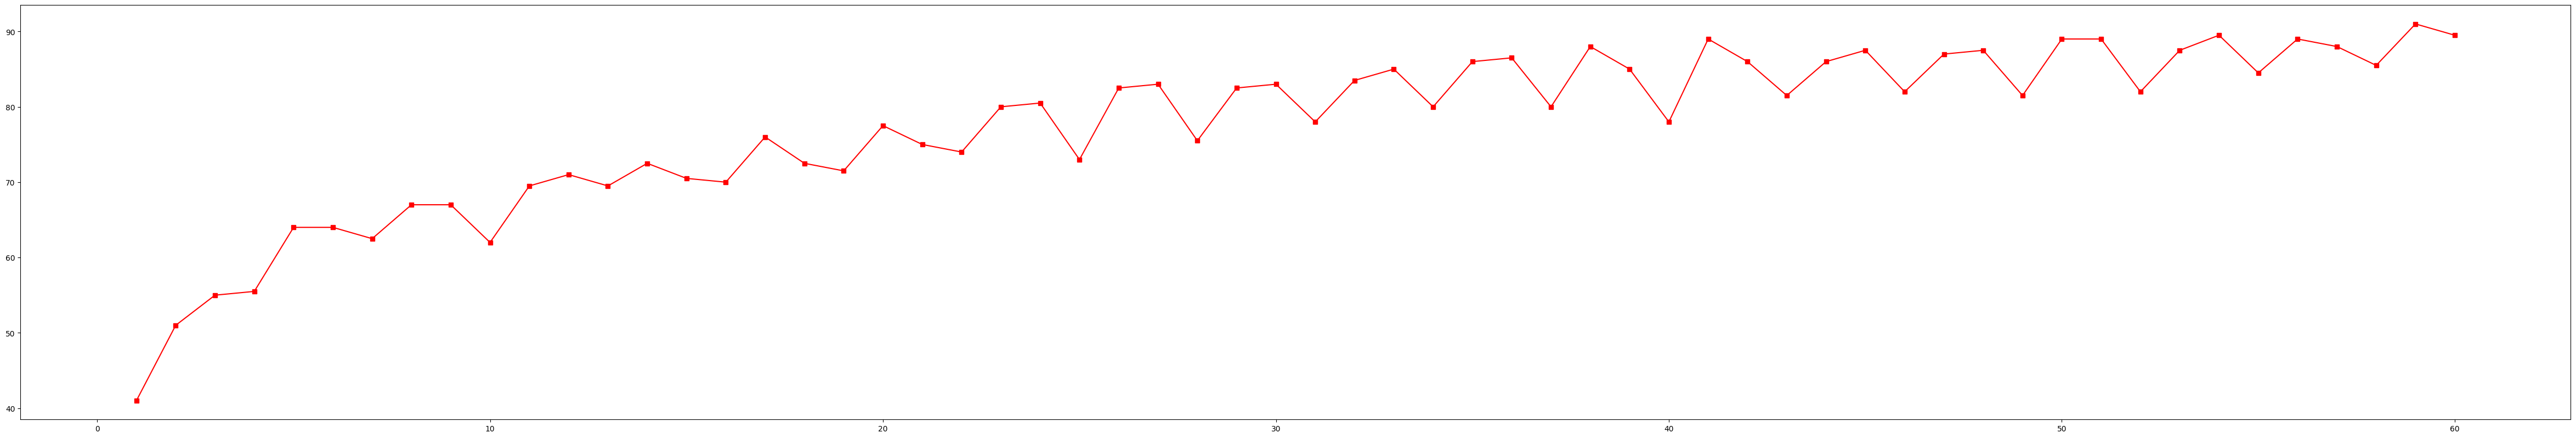

In [ ]:
plt.figure(figsize=(60,10),dpi=100,linewidth = 2)
plt.plot(iter,accuracy,'s-',color = 'r', label="TSMC")

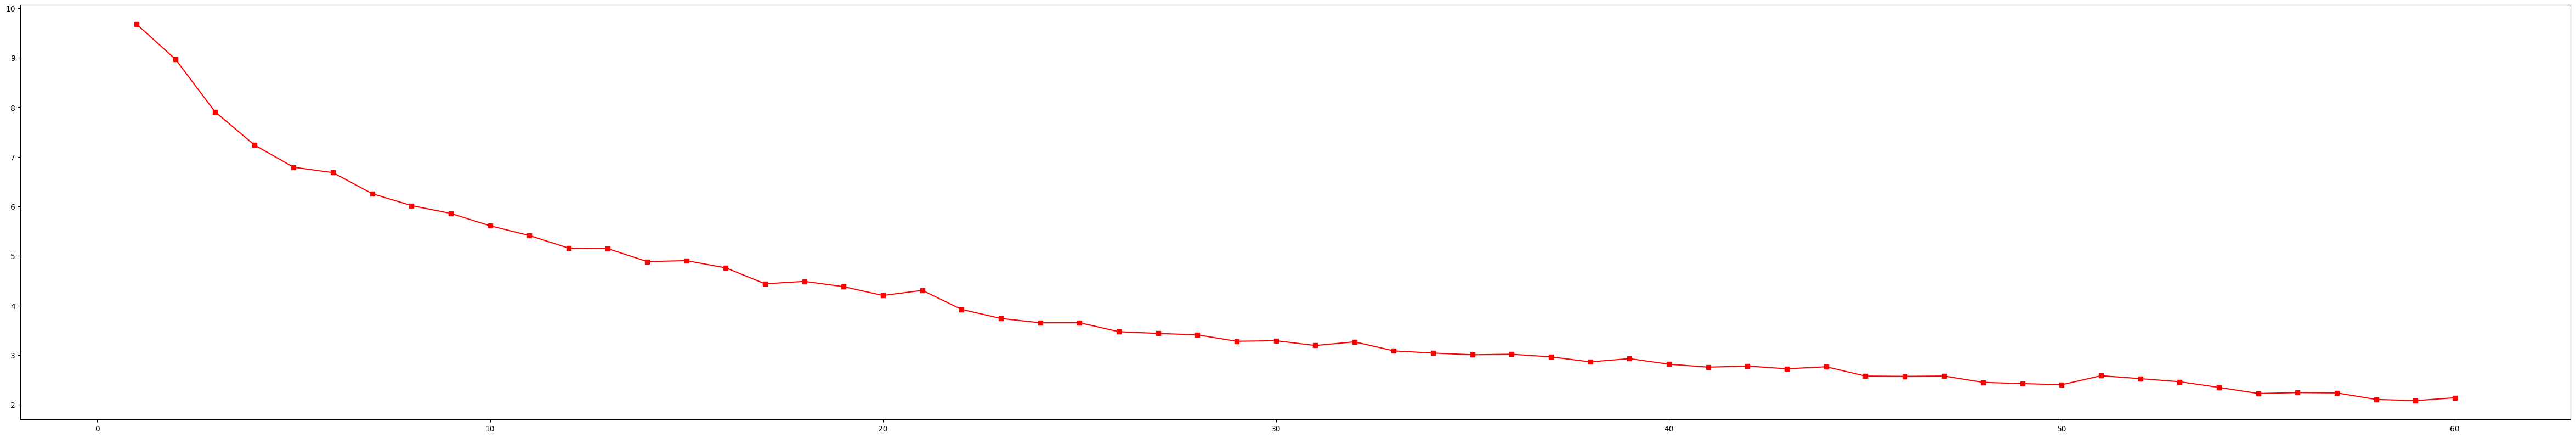

In [ ]:
plt.figure(figsize=(60,10),dpi=100,linewidth = 2)
plt.plot(iter,test_loss,'s-',color = 'r', label="TSMC")

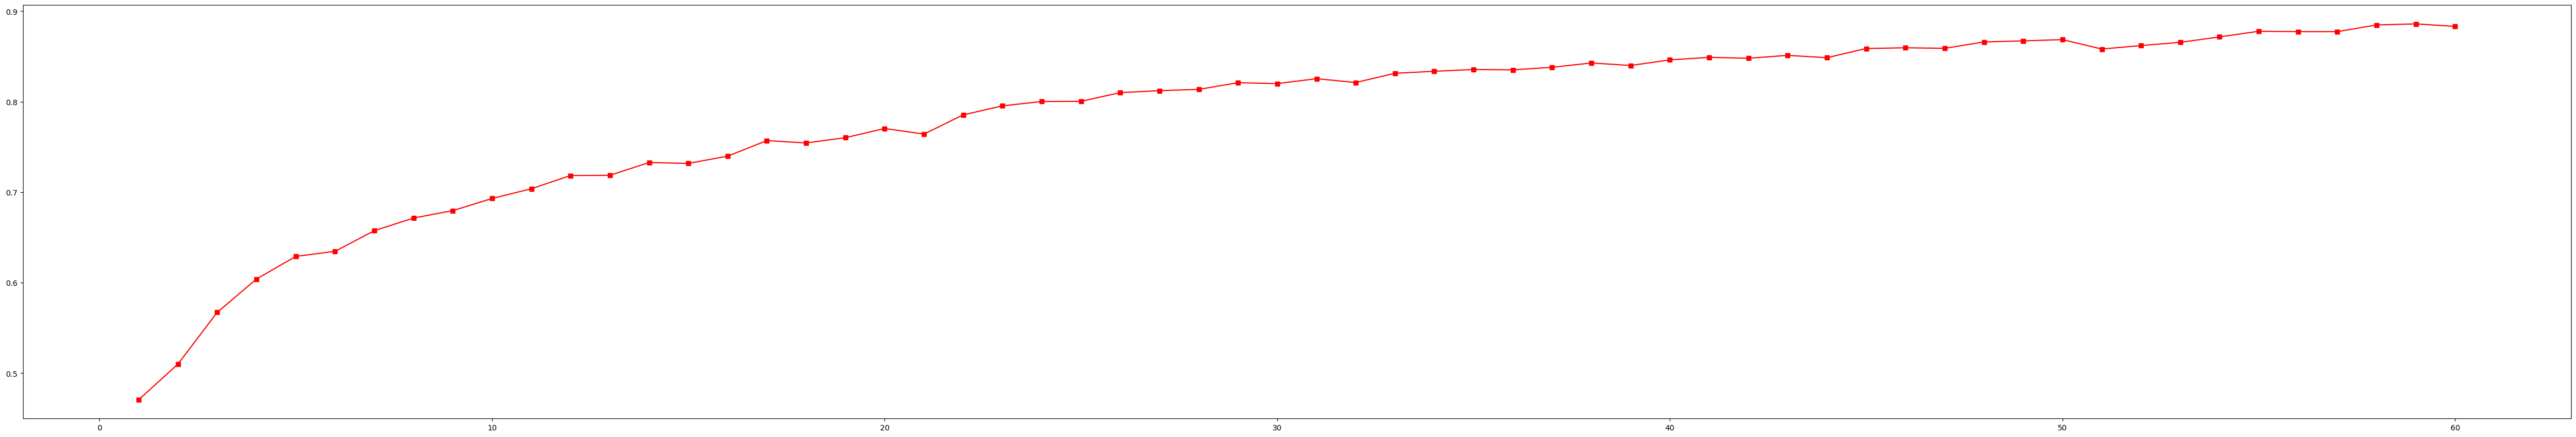

In [ ]:
plt.figure(figsize=(60,10),dpi=100,linewidth = 2)
plt.plot(iter,test_accuracy,'s-',color = 'r', label="TSMC")

## **1.** **Use zero Initialization**

In [ ]:
zero_ini_weight_1 = np.zeros((784, 2048))
zero_ini_weight_2 = np.zeros((2048, 512))
zero_ini_weight_3 = np.zeros((512, 5))

zero_ini_bias_1 = np.zeros((2048,))
zero_ini_bias_2 = np.zeros((512,))
zero_ini_bias_3 = np.zeros((5,))


In [ ]:
net = Model([FullyConnected(784,2048, zero_ini_weight_1, zero_ini_bias_1),Relu(),FullyConnected(2048,512, zero_ini_weight_2, zero_ini_bias_2),Relu(),FullyConnected(512,5, zero_ini_weight_3, zero_ini_bias_3),Softmax()], CrossEntropy())

In [ ]:
EPOCH = 20

In [ ]:
from tqdm import tqdm
loss = []
accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(1, EPOCH+1):
    print('epoch', epoch)
    
    train_loss=0
    val_loss=0
    train_hit = 0
    val_hit = 0
    total_train_loss = 0
    total_val_loss = 0
    for it in tqdm(range(train_batch_num)):
        #net.train()
        pred,lo = net.loss(train_norm[it*Batch_size:(it+1)*Batch_size], train_label_onehot[it*Batch_size:(it+1)*Batch_size])
        train_loss=lo.sum()
        #pred, train_loss = net.forward(train_data[it*Batch_size:(it+1)*Batch_size], train_label_onehot[it*Batch_size:(it+1)*Batch_size])
        #print('train_loss', train_loss)
        pred_index = np.argmax(pred, axis=1)
        #print('pred_index', pred_index)
        train_hit += (pred_index==train_y[it*Batch_size:(it+1)*Batch_size]).sum()
        #print('train_y', train_y[it*Batch_size:(it+1)*Batch_size])
        
        total_train_loss += train_loss
        
        net.backward()
        for layer in net.layers:
            if type(layer) == FullyConnected:
                #print('update w', Learning_rate * layer.grad_w)
                layer.weights -= Learning_rate * layer.grad_w
                layer.biases -= Learning_rate * layer.grad_b

        #net.eval()
        test_pred,lo = net.loss(test_norm, test_label_onehot)#.sum()
        val_loss=lo.sum()
        test_pred_index = np.argmax(test_pred, axis=1)
        hit = (test_pred_index==test_y).sum()
        val_hit += hit
        total_val_loss += val_loss

        if((it+1)%50 ==0):  
          loss.append(train_loss)
          accuracy.append((pred_index==train_y[it*Batch_size:(it+1)*Batch_size]).sum()/(Batch_size)*100.0)
          test_loss.append(val_loss)
          test_accuracy.append((test_pred_index==test_y).sum()/(test_image_num)*100.0)
   
        #print('Epoch:%3d'%epoch, '|Train Loss:%8.4f'%(total_train_loss/train_batch_num), '|Train Acc:%3.4f'%(train_hit/(train_image_num)*100.0) , '|Val Loss:%8.4f'%total_val_loss, '|Val Acc:%3.4f'%(val_hit/(test_image_num)*100.0))
        print('Epoch:%3d'%epoch, '|Train Loss:%8.4f'%(train_loss), '|Train Acc:%3.4f'%((pred_index==train_y[it*Batch_size:(it+1)*Batch_size]).sum()/(Batch_size)*100.0) , '|Val Loss:%8.4f'%(val_loss), '|Val Acc:%3.4f'%((test_pred_index==test_y).sum()/(test_image_num)*100.0))


   


> ### 1. Use zero initialization for the model weights make training process have less accuracy at the first. Moreover, all of the weights in the model will have the same value in subsequent iterations because the gradient is the same for every weights. 



# The learning curve

> black: training

> red:   testing





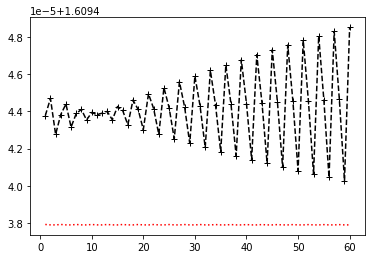

In [ ]:
import matplotlib.pyplot as plt
iter = []
for i in range(60):
    iter.append(i+1)
plt.plot(iter, loss, 'k--+')   # black dashed line, with "+" markers
plt.plot(iter, test_loss, 'r:')     # red dotted line (no marker)
plt.show()

# The classification accuracy

> black: training

> red:   testing





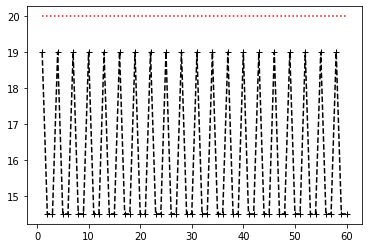

In [ ]:
plt.plot(iter, accuracy, 'k--+')   # black dashed line, with "+" markers
plt.plot(iter, test_accuracy, 'r:')     # red dotted line (no marker)
plt.show()

# **2. Add dropout layer**

In [ ]:
class Dropout():
    def __init__(self, p=0.8): #non 0 - 0.8
        self.p = p
        self.binary_value=None
        self.training = True
    def train(self):
        self.training = True
    def eval(self):
        self.training = False
    def forward(self, weights):
        #u1 = np.random.binomial(1, p, size=weights.shape)
        #weights *= u1
        if self.training:
          #print('before dropout weight', weights)
          self.binary_value = np.random.rand(weights.shape[0], weights.shape[1]) < self.p
          
          #print('mask', self.binary_value)
          res = np.multiply(weights, self.binary_value)
          #print('count', np.count_nonzero(res.flatten())/ res.flatten().shape[0])
          weights = res/self.p
          #print('after dropout weight', weights)
        return weights
    def backward(self,grad):
      if self.training:
        grad *= self.binary_value
        grad/=self.p

      return grad


In [ ]:
net = Model([FullyConnected(784,2048, init_weights[0], init_biases[0]), Dropout(0.8),Relu(),FullyConnected(2048,512, init_weights[1], init_biases[1]), Dropout(0.8),Relu(),FullyConnected(512,5, init_weights[2], init_biases[2]),Softmax()], CrossEntropy())

In [ ]:
loss = []
accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(1, EPOCH+1):
    print('epoch', epoch)
    
    train_loss=0
    val_loss=0
    train_hit = 0
    val_hit = 0
    total_train_loss = 0
    total_val_loss = 0
    for it in tqdm(range(train_batch_num)):
        net.train()
        pred,lo = net.loss(train_norm[it*Batch_size:(it+1)*Batch_size], train_label_onehot[it*Batch_size:(it+1)*Batch_size])
        train_loss=lo.sum()
        #pred, train_loss = net.forward(train_data[it*Batch_size:(it+1)*Batch_size], train_label_onehot[it*Batch_size:(it+1)*Batch_size])
        #print('train_loss', train_loss)
        pred_index = np.argmax(pred, axis=1)
        #print('pred_index', pred_index)
        train_hit += (pred_index==train_y[it*Batch_size:(it+1)*Batch_size]).sum()
        #print('train_y', train_y[it*Batch_size:(it+1)*Batch_size])
        
        total_train_loss += train_loss
        
        net.backward()
        for layer in net.layers:
            if type(layer) == FullyConnected:
                #print('update w', Learning_rate * layer.grad_w)
                layer.weights -= Learning_rate * layer.grad_w
                layer.biases -= Learning_rate * layer.grad_b

        net.eval()
        test_pred,lo = net.loss(test_norm, test_label_onehot)#.sum()
        val_loss=lo.sum()
        test_pred_index = np.argmax(test_pred, axis=1)
        hit = (test_pred_index==test_y).sum()
        val_hit += hit
        total_val_loss += val_loss

        if((it+1)%50 ==0):  
          loss.append(train_loss)
          accuracy.append((pred_index==train_y[it*Batch_size:(it+1)*Batch_size]).sum()/(Batch_size)*100.0)
          test_loss.append(val_loss)
          test_accuracy.append((test_pred_index==test_y).sum()/(test_image_num)*100.0)
   
        print('Epoch:%3d'%epoch, '|Train Loss:%8.4f'%(train_loss), '|Train Acc:%3.4f'%((pred_index==train_y[it*Batch_size:(it+1)*Batch_size]).sum()/(Batch_size)*100.0) , '|Val Loss:%8.4f'%(val_loss), '|Val Acc:%3.4f'%((test_pred_index==test_y).sum()/(test_image_num)*100.0))
    
    #print('---Epoch:%3d'%epoch, '|Train Loss:%8.4f'%(total_train_loss/train_batch_num), '|Train Acc:%3.4f'%(train_hit/(train_batch_num*(train_image_num)*100.0)) , '|Val Loss:%8.4f'%(total_val_loss/train_batch_num), '|Val Acc:%3.4f'%(val_hit/(train_batch_num*(test_image_num)*100.0)))


   

# The classification accuracy

> black: training

> red:   testing





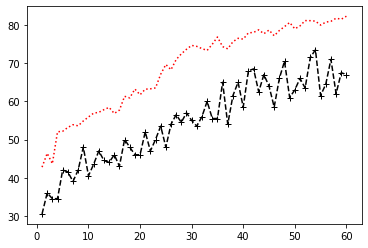

In [ ]:
plt.plot(iter, accuracy, 'k--+')   
plt.plot(iter, test_accuracy, 'r:')     
plt.show()

# The learning curve

> black: training

> red:   testing





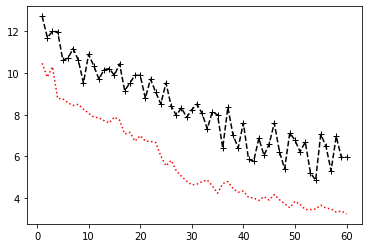

In [ ]:
plt.plot(iter, loss, 'k--+')   # black dashed line, with "+" markers
plt.plot(iter, test_loss, 'r:')     # red dotted line (no marker)
plt.show()